# Interpolation and Smoothing

In [1]:
from all_imports import *
%matplotlib inline                        

## I. Key concepts

In the previous lecture on Curve Fitting we talked about how that can help to 
* Smooth out noisy data
* Allow for interpolation, extrapolation, and other mathematical operations

The downsides of Curve Fitting are it
* Requires a careful choice of **function** that depends on each particular set of data--it may be hard to develop a physical model, and a polynomial may not work well
* Uses a **global** approach in which all the data are examined and all the fitting parameters are developed simultaneously, as a big and expensive set of equations

Therefore, when you have large, irregular, or continuous data streams, curve fitting is not necessarily convenient. The data may be noisy and the physical model inadequate, but at least we have a lot of data! We are motivated in those cases to use **local** interpolation and estimation methods which are more efficient.

### The basic problem of interpolation and estimation

* Given two arrays of data points ($x_g$ and $y_g$) where samples $y_g$ may have random errors included
* Estimate the "true" value $y_w$ at some location $x_w$ that may not be exactly at any of the points $x_g$.


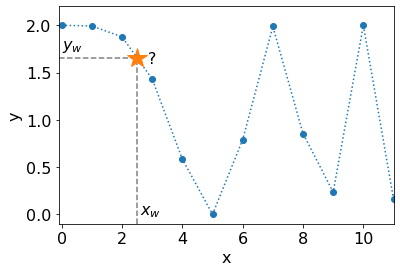

In [2]:
#### Just plotting some data to visualize

x_given = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])
y_given = np.cos(x_given**2.0/8.0) + 1

plt.rc('font', size=16)
plt.plot(x_given, y_given, 'o:')
plt.plot([2.5,2.5],[-0.1,1.65], '--', color='gray')
plt.plot([-0.1,2.5],[1.65,1.65], '--', color='gray')
plt.plot([2.5], [1.65], '*', markersize=20)
plt.xlim([-0.1,11])
plt.ylim([-0.1,2.2])
plt.xlabel('x')
plt.ylabel('y')
plt.text(2.6,0, r"$x_w$", fontsize=16)
plt.text(0,1.75, r"$y_w$", fontsize=16)
plt.text(2.85,1.6, "?", fontsize=16);

To get that intermediate value $y_w$, we often interpolate between nearby points while ignoring points far away.

**Linear interpolation** is to put a straight line between the two closest sample points and find our point of interest on that line. Because we are only considering two samples at a time, we are breaking the problem into an easy _local_ problem. We are assuming the noise in the samples is negligible and that the points are close enough together that curvature doesn't matter.

Can we do **higher order interpolation**? 
* **Splines** are piecewise polynomials that are fit between just a few points--can account for curvature between sample points 
* **Kernel Smoothing** is another approach in the case that we want to suppress the noise while interpolating
* Methods have been developed for 1D data, but also for 2D, 3D, etc.

### Concept review
How does curve fitting differ from interpolation?


## II. 1D Interpolation

### Scipy's interpolator


* ```interp1d``` takes the sample $x$ and $y$ arrays as arguments
* **Returns a function** 
* Call that function to do the interpolation at a particular $x$ value
* The default is _linear_ interpolation

In [3]:
xg = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12])   # given x data
yg = np.cos(xg**2.0/8.0)+1                      # given y data

#---------------

f_interp = interp1d(xg, yg)

#---------------

xw = 2.5
yw = f_interp(xw)

print(yw)
np.cos(xw**2.0/8.0)+1

1.6543795393445195


1.7100338835660795

### Exercise
Below is a plot of the above `xg`, `yg` data as points. Add to this plot:

* A smooth curve of the underlying function used to get the `yg` values. To do this make new arrays `xx` and `yy`
* A curve representing the linear interpolation generated by `interp1d` at the same points as `xx`.


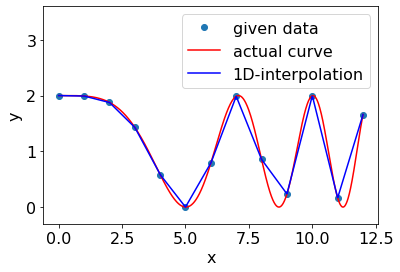

In [11]:
xg = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12]) # given x data
yg = np.cos(xg**2/8.)+1                # given y data

xx = np.linspace(0, 12, 1000)
yy = np.cos(xx**2/8.)+1
yi = f_interp(xx)

plt.plot(xg, yg, 'o',label='given data')
plt.plot(xx, yy, 'r-',label='actual curve')
plt.plot(xx, yi, 'b-',label='1D-interpolation')

plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-0.3,3.6])
plt.legend(loc='best');

### Cubic Spline 

* You can use a *cubic spline* interpolant instead of a linear interpolant. 
* This means cubic polynomials are used between every two points. The piecewise functions are made to match up smoothly where they meet.
* Add the following keyword argument (called a `kwarg`) to your interpolation function:  
```f_interp = interp1d(xg, yg, kind='cubic')```

### Extrapolation

* What happens if you try to extrapolate your interpolation function, that is, use an `x` value outside of the bounds of the sample ```xg``` data?
* Now try using the following keyword argument:  
```f_interp = interp1d(xg, yg, fill_value='extrapolate')```

### Summary
1. Import library
1. You have some data from somewhere, ```xg```, ```yg```
1. Get the interpolant function ```fi=interp1d(xg, yg)```
1. Set desired ```xw``` intermediate points to interpolate at (can be an array).
1. Perform the interpolation to ```yw=fi(xw)```

### Question
* What if you have given ```xg``` and ```yg``` arrays and you know the ```yw``` and want to interpolate to the corresponding ```xw```?

## III. Smoothing Kernel

Smoothing kernel techniques are used to _estimate_ the real (underlying) value of noisy data.

The estimated $y_w$ is a weighted average of sample points $y_i$ in its vicinity, where the weight $w_i$ is given by a kernel function: $$y_w = \frac{\sum_i w_i y_i}{\sum_i w_i}$$ The denominator is to make sure the weights are properly normalized. 

Weights depend on the distance between the estimated and sampled points: weight should be large when the two are close and weak when the two are far from each other. The Gaussian kernel is popular: $$w_i = \exp \left[ - \tfrac{1}{2}\left(\frac{x_w - x_i}{\sigma} \right)^2 \right]$$ where $\sigma$ in this case is a smoothing length parameter. It is the only parameter you need to choose. It should be adjusted to be large enough that any point for estimation is within $\sigma$ distance from at least one sampled point.

    

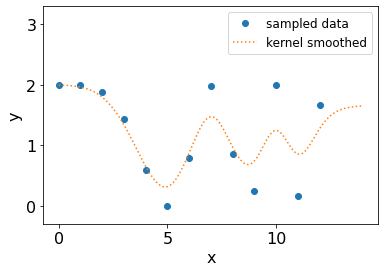

In [5]:
xg = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12]) # given x data
yg = np.cos(xg**2/8.)+1                # given y data

def kernel(xw,xi,σ=1):                  # weight given by the kernel function
    return np.exp(-0.5*((xw-xi)/σ)**2)  # this is a Gaussian

σ = 0.7  # experiment with the smoothing length to see how this affects the smoothed curve

def smoother(xw,xg,yg):
    sumwy = 0.      # initialize accumulators
    sumw = 1E-20    # the use of small number (instead of 0) is to avoid divide-by-zero errors
    for i in range(len(xg)):
        wi = kernel(xw,xg[i],σ) # weight for this point
        sumwy += wi*yg[i]
        sumw += wi
    return sumwy/sumw

xw = np.linspace(0,14,1000) # lots of points including some that are extrapolated
yw = smoother(xw,xg,yg)     # call kernel smoother on whole array of xw points

plt.plot(xg, yg, 'o', label='sampled data')
plt.plot(xw, yw, ':', label='kernel smoothed')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-0.3,3.3])
plt.legend(loc='best', fontsize=12);

Test out different values of $\sigma$. A smoothing kernel can act more like a fitting curve (ability to smooth) or more like a spline interpolation (going exactly through every sample point), depending on $\sigma$. Different kernel functions (i.e. besides Gaussian) have different effects as well.

### Additional information

Smoothing techniques are used in image processing. _Gaussian blur_, a technique used to clean up noisy images or intentionally defocus a portion of a photo, is actually just Gaussian kernel smoothing applied in two dimensions. See
https://en.wikipedia.org/wiki/Gaussian_blur

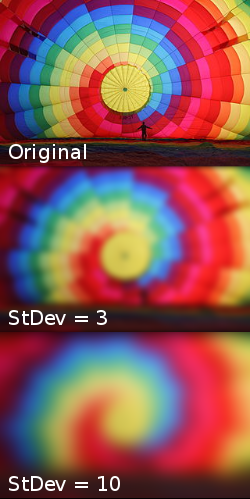